In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import datetime
import json
import tensorflow as tf
from tqdm.keras import TqdmCallback
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.optimizers.experimental import AdamW
from tensorflow.keras.losses import MeanSquaredError

sns.set_theme()

try: # are we in Colab?
    import google.colab
    COMPUTE_ENV = 'colab'
    print('Running in Colab.')
    google.colab.drive.mount('/content/gdrive')
    OUTPUT_DIR = "/content/gdrive/My Drive/output"
    !git clone https://github.com/FriedChips/dl_basics.git
    sys.path.insert(0,'/content/dl_basics')
except: # if not...
    if "kaggle" in os.environ["PWD"]: # are we in Kaggle?
        COMPUTE_ENV = 'kaggle'
        print('Running in Kaggle.')
        !git clone https://github.com/FriedChips/dl_basics.git
        sys.path.insert(0,'../working/dl_basics')    
        OUTPUT_DIR = "./"
    else: # we're local
        COMPUTE_ENV = os.uname()[1]
        print(f"Running locally on {COMPUTE_ENV}.")
        sys.path.insert(0,'./../')
        OUTPUT_DIR = "../output/"

for gpu in tf.config.list_physical_devices("GPU"):
    print(f"Found GPU: {tf.config.experimental.get_device_details(gpu)['device_name']}.")

Running locally on beta.


In [2]:
from data_gen.synth_sequences import SynthNNumbers
import models
import utils

In [3]:
P = {}

P["SynthNNumbers"] = {
    "batch_size" : 64,
    "n" : 2,
    "operation" : "multiply",
    "limit" : 2,
    "distribution" : "uniform",
    "seed" : 42,
}

data_gen = SynthNNumbers(**P["SynthNNumbers"])
x, y = data_gen.__getitem__(1)
print(x.shape, x.dtype, y.shape, y.dtype)
print(x[0], y[0])

(64, 2) float32 (64,) float32
[ 1.0958242  -0.24448624] -0.26791394


In [7]:
# init new run

'''
P["model_name"] = "gru_01"
P["model_build_params"] = {
    "gru_units" : 32,
    "num_outputs" : 1,
    "input_shape" : (P["SynthMathData"]["seq_len"], 2),
    "num_hidden_gru" : 3,
    "use_embedding" : False,
    "return_final_hidden" : True,
}

model = tf.keras.Sequential([
    tf.keras.Input(shape=(P["SynthNNumbers"]["n"],)),
    utils.Quadratic(1)
])

'''

P["model_name"] = "mlp_01"
P["model_build_params"] = {
    "input_shape" : (P["SynthNNumbers"]["n"],),
    "layer_units" : [ 128, 1 ],
    "activations" : [ "relu", "linear" ],
    "use_bias" : False,
}

P["random_seed"] = 42
utils.tf_keras_random_seed(P["random_seed"])

model = eval("models." + P["model_name"])(**P["model_build_params"])
model.summary()

P["loss"] = "MeanSquaredError()"
P["optimizer"] = "AdamW(1e-3, weight_decay=1)"
#P["optimizer"] = "SGD(1e-0, momentum=0.9)"
P["metrics"] = [ "mae" ]
model.compile(loss = eval(P["loss"]), optimizer = eval(P["optimizer"]), metrics = P["metrics"])

P["run_dir"] = model.name + datetime.datetime.now().strftime('-%y%m%d-%H%M%S')
LOG_DIR = os.path.join(OUTPUT_DIR, P["run_dir"])

print("Log dir :", LOG_DIR)

run = utils.TrainingRun()
weight_norm_logger = utils.LogWeightNorms()
#weight_logger = utils.SaveWeightsPower2(LOG_DIR)

Model: "mlp_01"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2)]               0         
                                                                 
 dense_0 (Dense)             (None, 128)               256       
                                                                 
 tf.nn.relu (TFOpLambda)     (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 128       
                                                                 
Total params: 384
Trainable params: 384
Non-trainable params: 0
_________________________________________________________________
Log dir : ../output/mlp_01-230420-111121


In [12]:
NUM_EPOCHS = 1024
#lr_sched = utils.Schedule_ExpCos_Segments([[-3,-3, NUM_EPOCHS]])

history = model.fit(
    data_gen,
    epochs = NUM_EPOCHS,
    callbacks=[
        TqdmCallback(verbose=0),
        weight_norm_logger,
    ],        
    verbose=0)

run.update_history(history)

0epoch [00:00, ?epoch/s]

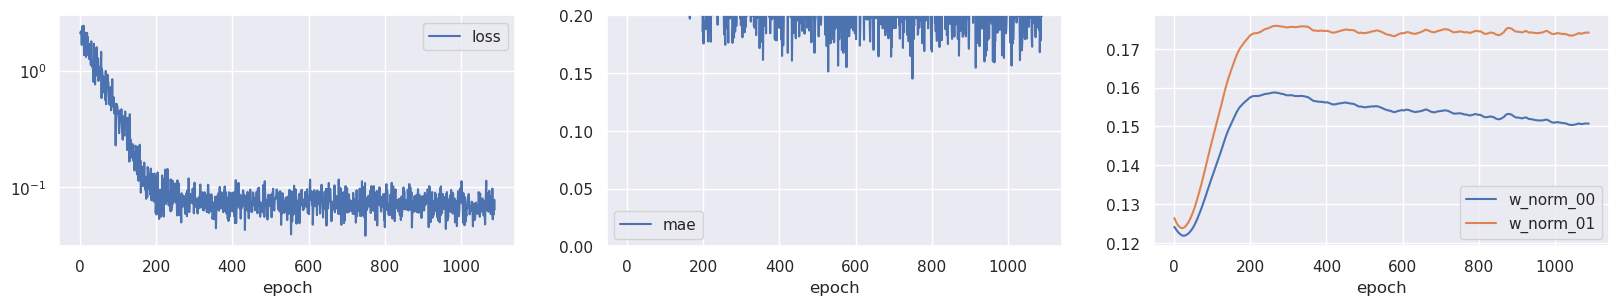

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(20,3))

sns.lineplot(data=run.history[["loss"]], ax=axs[0], dashes=False);
axs[0].set_yscale("log");

sns.lineplot(data=run.history[["mae"]], ax=axs[1], dashes=False);
axs[1].set_ylim(0,0.2);

sns.lineplot(data=weight_norm_logger.norms_dataframe(), ax=axs[2], dashes=False);

In [25]:
log_dir = os.path.join(OUTPUT_DIR, P["run_dir"])
run.save_state(log_dir, P, model)
weight_norm_logger.norms_to_csv(log_dir)

2/2 [==============================] - 0s 8ms/step


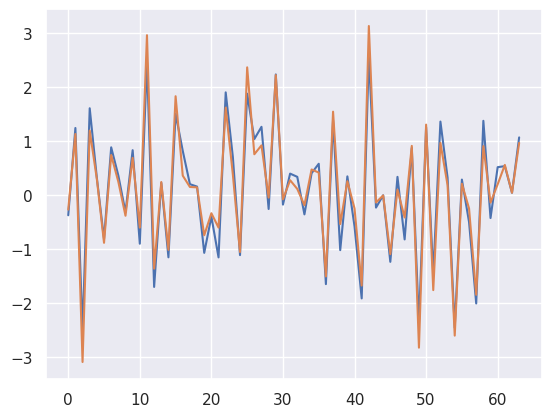

In [14]:
y_pred = model.predict(x)
plt.plot(y_pred)
plt.plot(y)

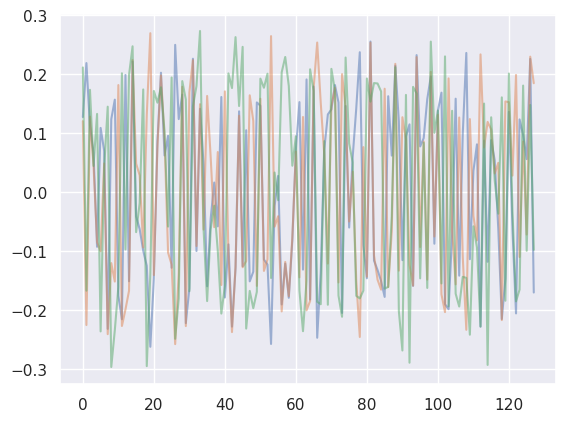

In [15]:
plt.plot(model.get_weights()[0].T, alpha=0.5);
plt.plot(model.get_weights()[1], alpha=0.5);

313/313 [==============================] - 0s 1ms/step


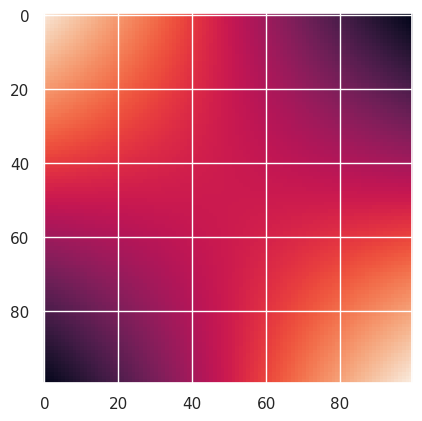

In [36]:
x_test = np.array([ [x1, x2] for x2 in np.linspace(-1,1,100) for x1 in np.linspace(-1,1,100) ])
y_test = np.prod(x_test, axis=-1)

y_pred = model.predict(x_test)

plt.imshow(y_pred.reshape(100,100));

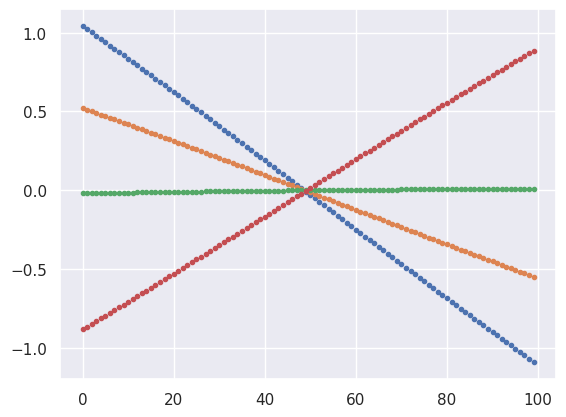

In [37]:
plt.plot(y_pred.reshape(100,100)[0], ".");
plt.plot(y_pred.reshape(100,100)[25], ".");
plt.plot(y_pred.reshape(100,100)[50], ".");
plt.plot(y_pred.reshape(100,100)[90], ".");